#Part 1

In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.4 MB/s eta 0:00:00


In [2]:
from pathlib import Path
from typing import NamedTuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

sns.set_theme()


In [3]:
#code referenced from frozenlake becnhmark tutorial:  https://gymnasium.farama.org/tutorials/training_agents/FrozenLake_tuto/
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved


params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("../../_static/img/tutorials/"),
)
params

rng = np.random.default_rng(params.seed)
params.savefig_folder.mkdir(parents=True, exist_ok=True)


In [4]:
class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        self.qtable = np.zeros((self.state_size, self.action_size))


class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        explor_exploit_tradeoff = rng.uniform(0, 1)

        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        else:

            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :])
        return action


In [5]:
def run_env(params):
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):
        learner.reset_qtable()
        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                all_states.append(state)
                all_actions.append(action)

                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                state = new_state

            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions


In [6]:
def postprocess(episodes, params, rewards, steps, map_size):
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

In [7]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [8]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")


    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [9]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

Map size: 4x4


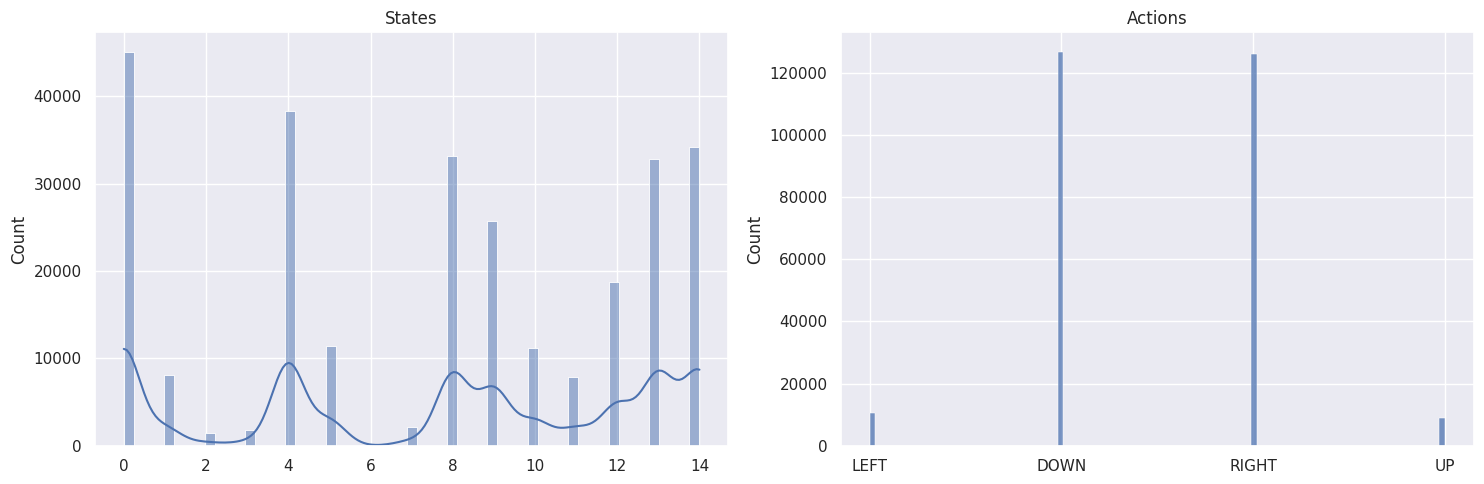

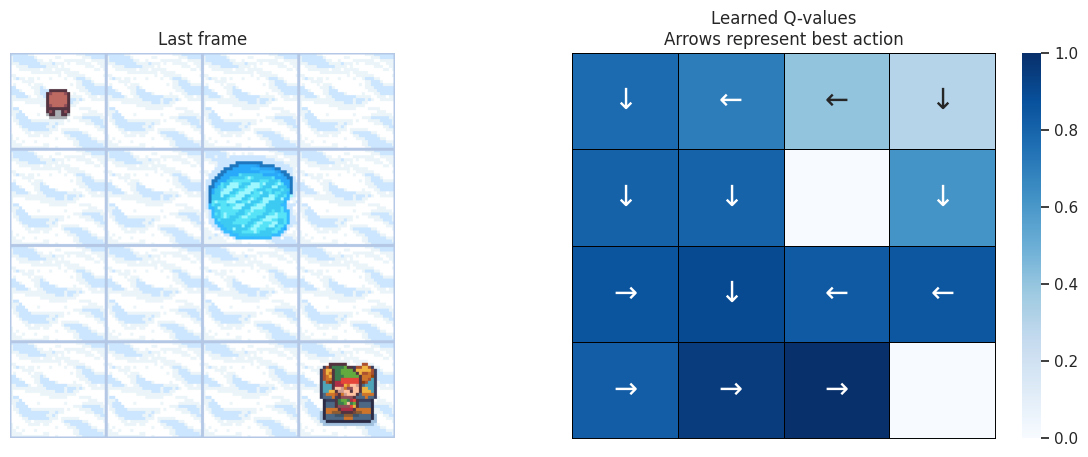

Map size: 7x7


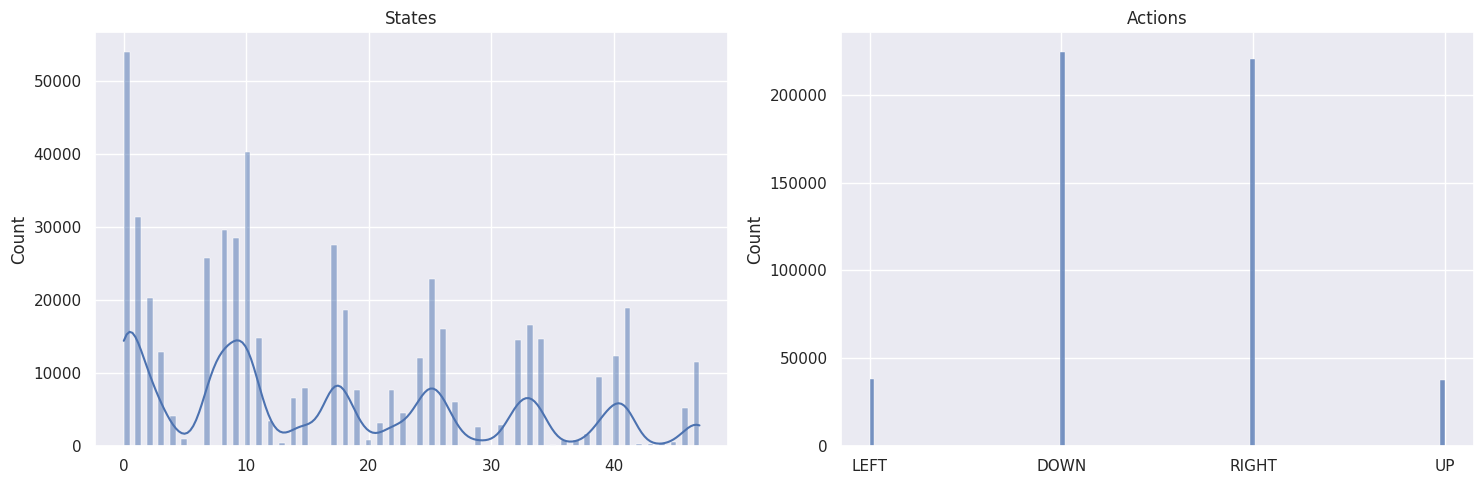

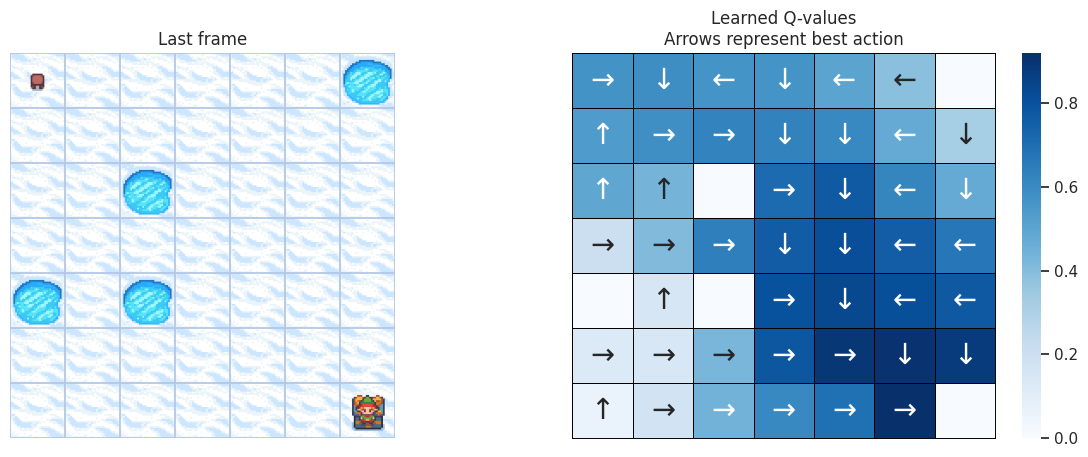

Map size: 9x9


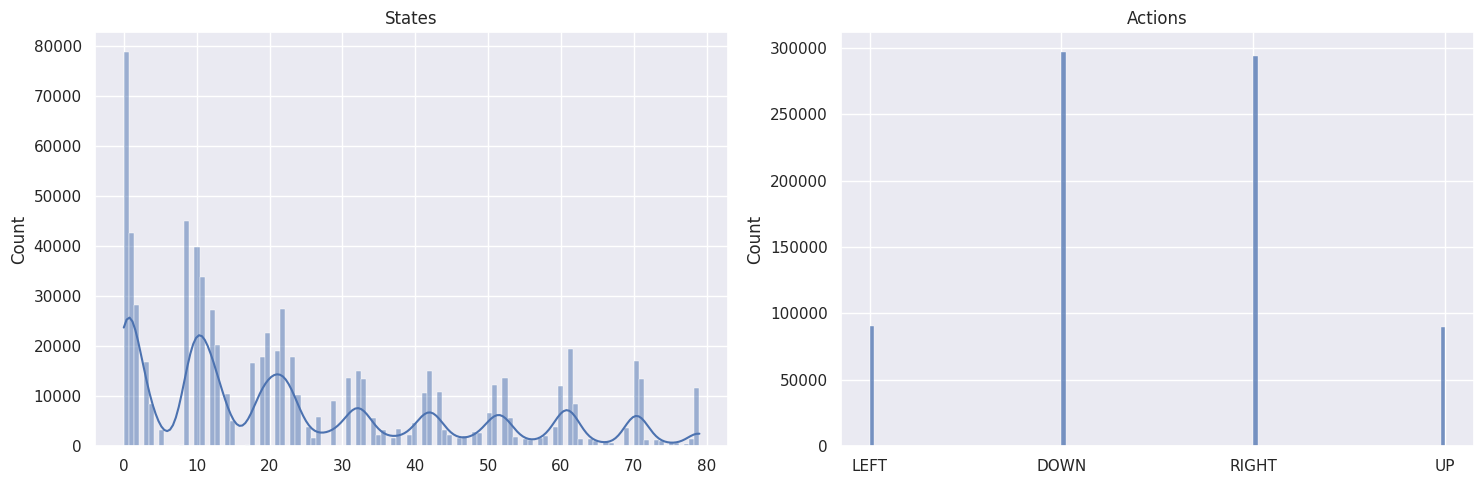

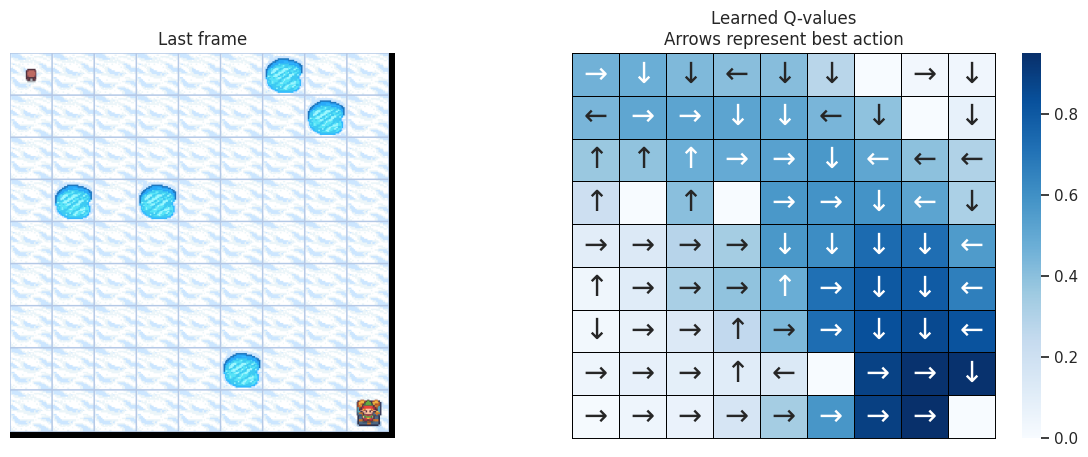

Map size: 11x11


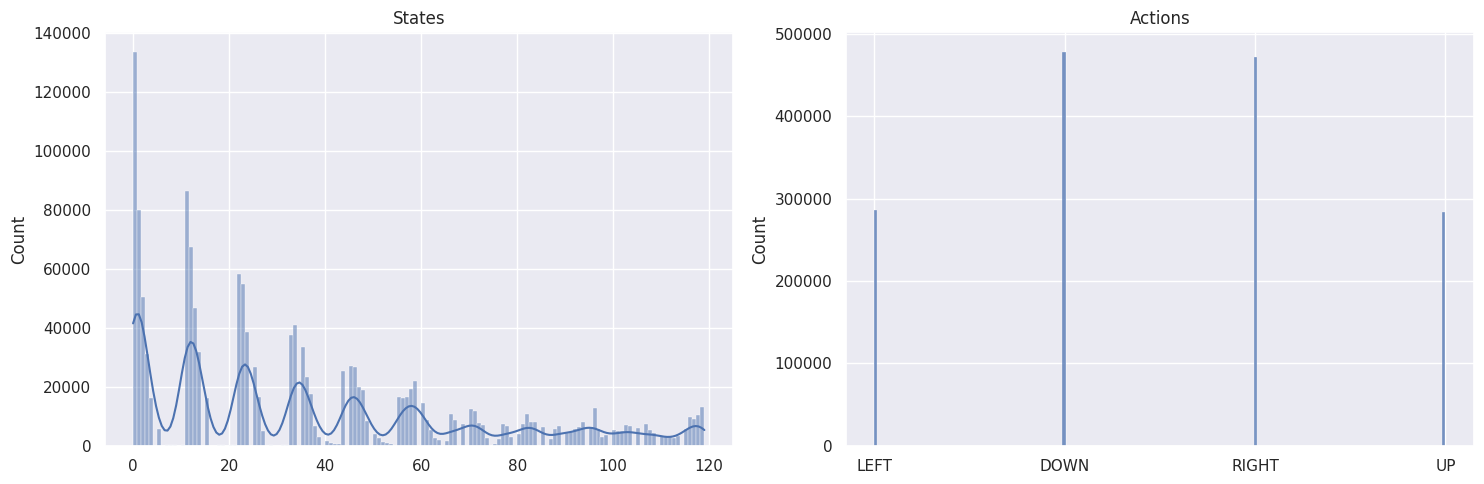

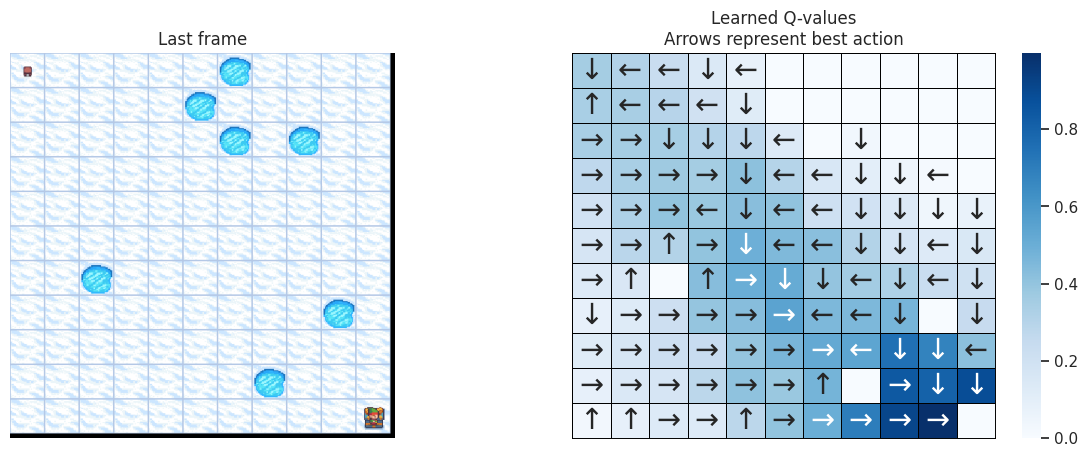

In [10]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env(params)


    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )
    plot_q_values_map(qtable, env, map_size)


    env.close()

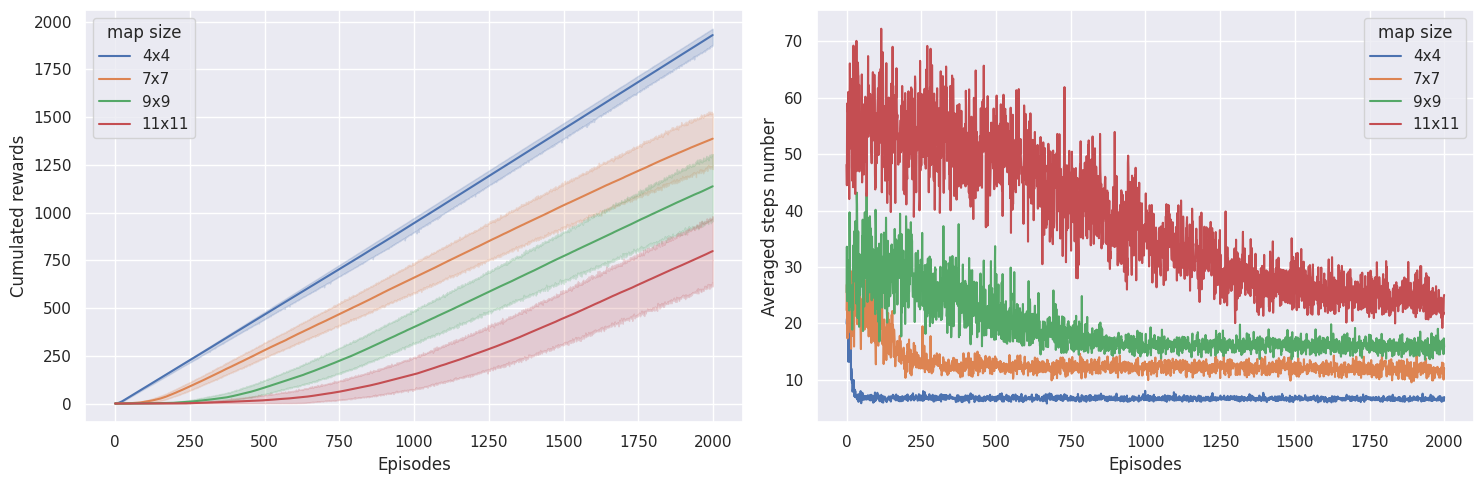

In [11]:
def plot_steps_and_rewards(rewards_df, steps_df):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


plot_steps_and_rewards(res_all, st_all)

#Hyperparameter configuration 1

In [12]:
ht_params1 = params._replace(
                    learning_rate=0.5,
                    gamma=0.99,
                    epsilon= 0.1
                )


Map size: 4x4


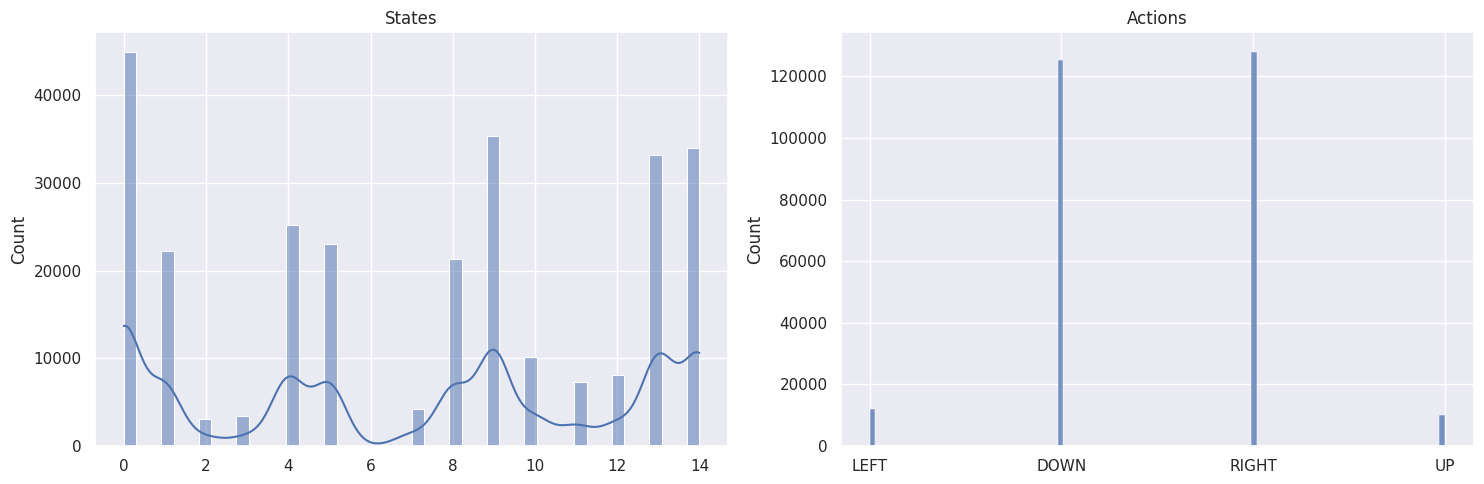

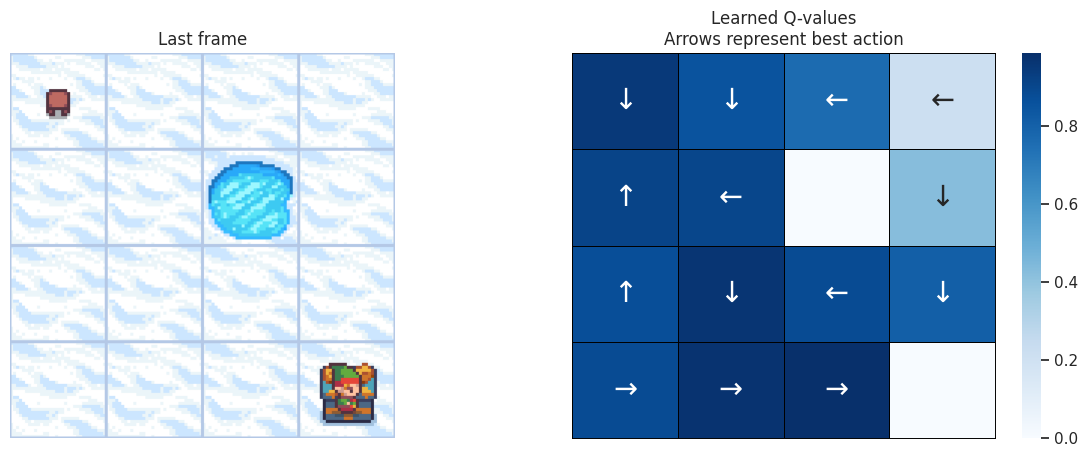

Map size: 7x7


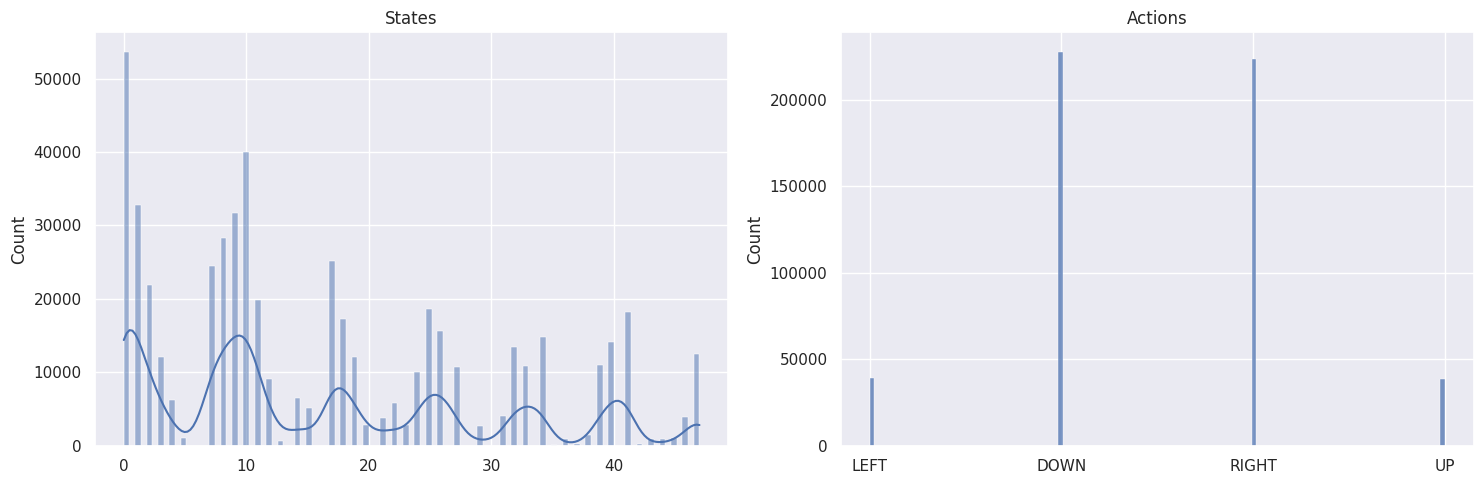

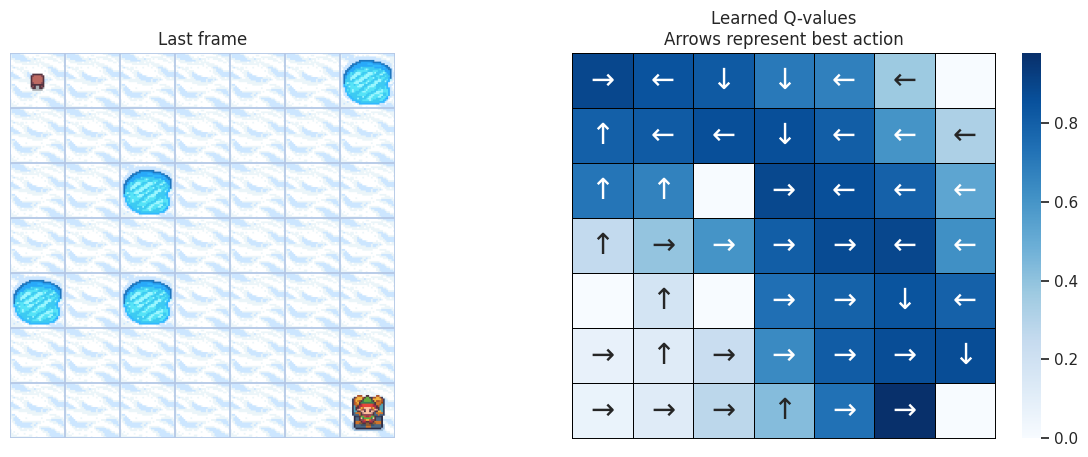

Map size: 9x9


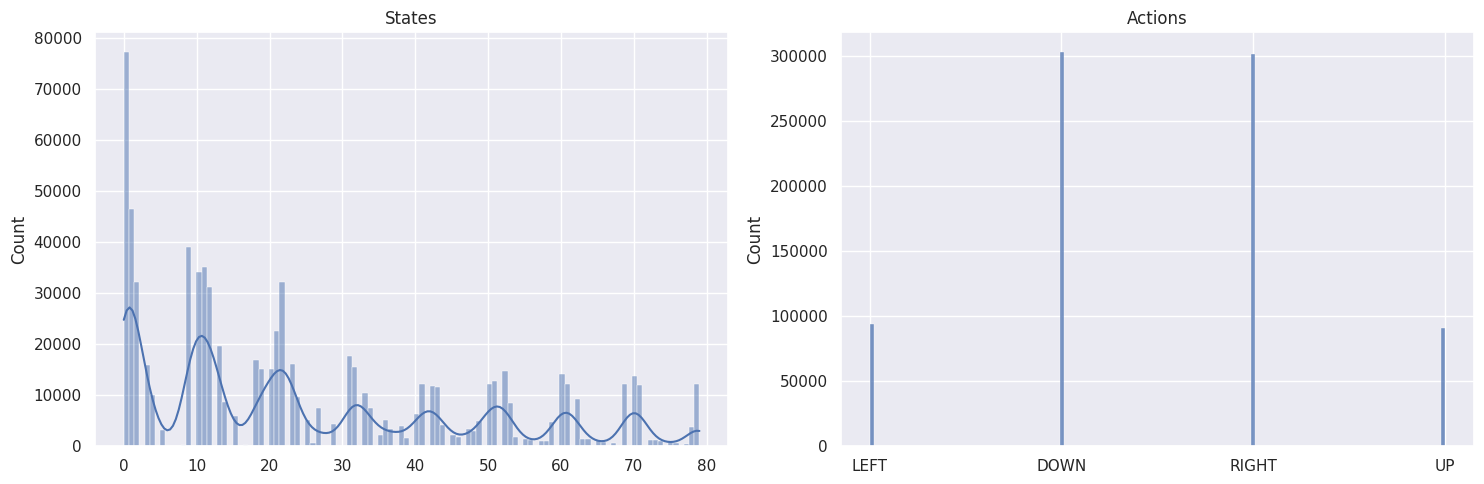

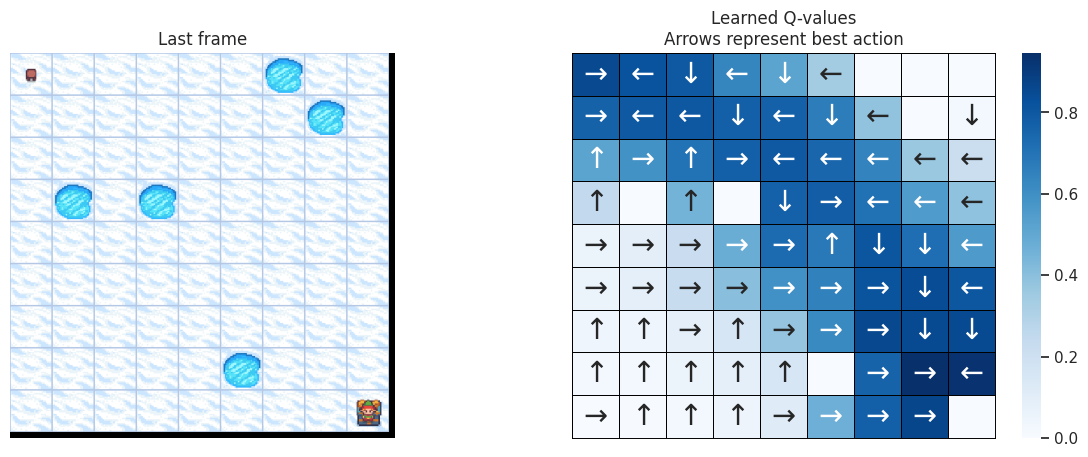

Map size: 11x11


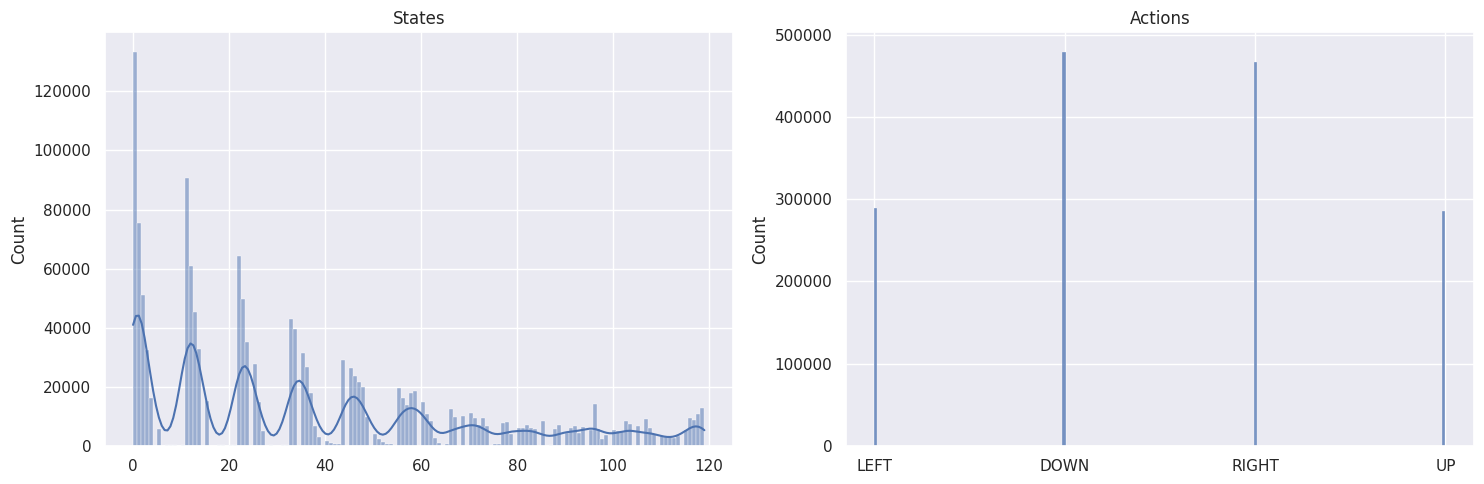

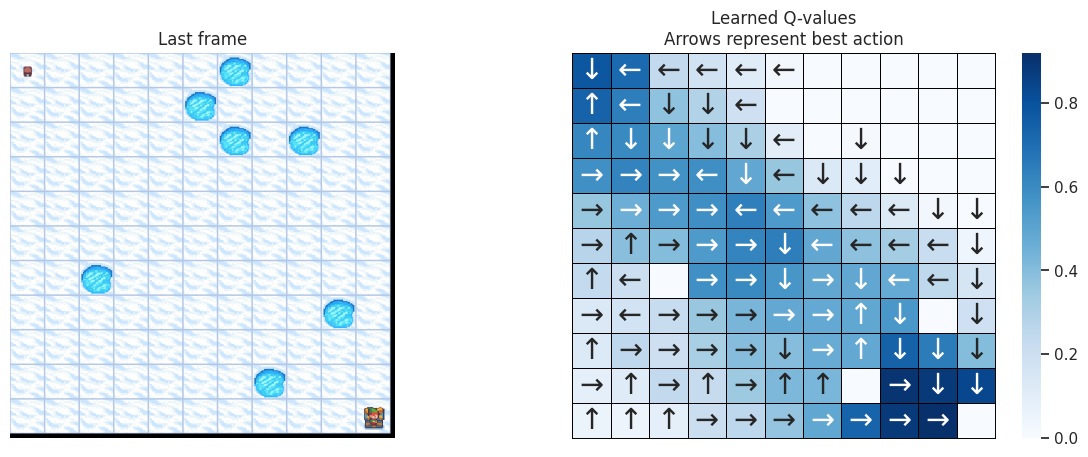

In [13]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=ht_params1.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=ht_params1.proba_frozen, seed=ht_params1.seed
        ),
    )

    ht_params1 = ht_params1._replace(action_size=env.action_space.n)
    ht_params1 = ht_params1._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        ht_params1.seed
    )
    learner = Qlearning(
        learning_rate=ht_params1.learning_rate,
        gamma=ht_params1.gamma,
        state_size=ht_params1.state_size,
        action_size=ht_params1.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=ht_params1.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env(ht_params1)


    res, st = postprocess(episodes, ht_params1, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )
    plot_q_values_map(qtable, env, map_size)

    env.close()

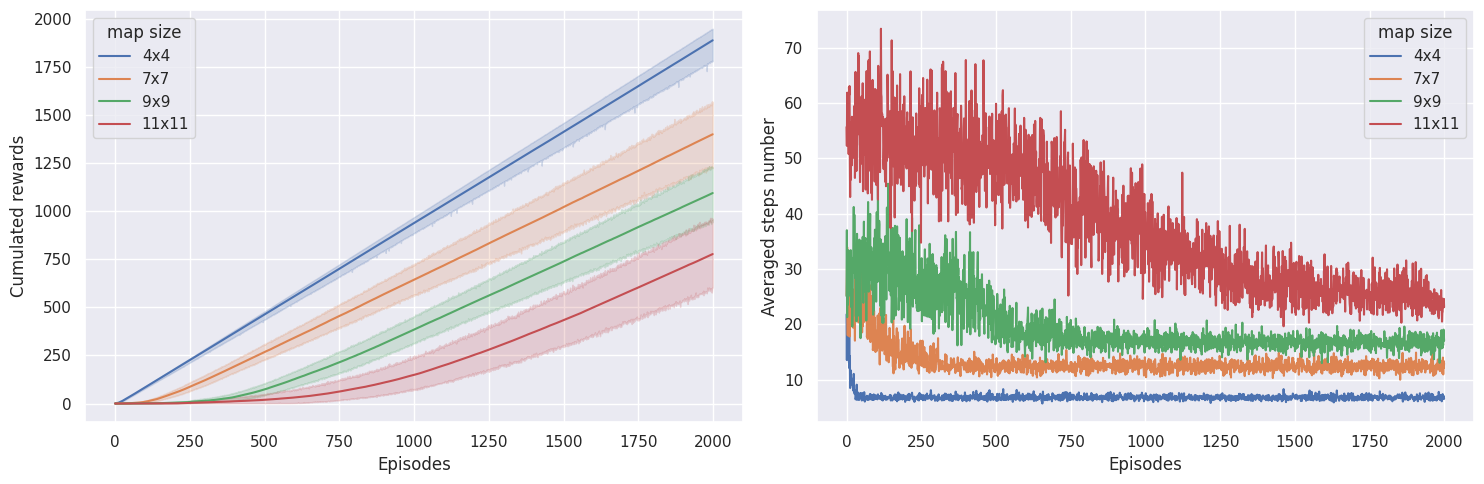

In [14]:
plot_steps_and_rewards(res_all, st_all)

This hyperparamter configuration (alpha = 0.5, gamma = 0.99, epsilon = 0.1) appears effective across all map sizes. Both graphs indicate that the agent's performance improves with training.  
The epsilon has a high value which can help explore better. The alpha helps in stability. Lowering the alpha migh help even more. The gamma value is high, lowering this value will increase the learning process.

Policy Iteration algorithm

In [15]:
class PolicyIter:
  def __init__(self, g, t = 0.0001):
    self.gamma = g
    self.theta = t

  def evalp(self, pol, env, x):
    while True:
      d = 0
      for o in range(env.observation_space.n):
        v = x[o]
        nv = 0
        for i,j in enumerate(pol[o]):
          for p, q, r, s in env.P[o][i]:
            nv += j * p * (r + self.gamma * x[q])

        d = max(d, abs(x[o] - nv))
        x[o] = nv

      if d < self.theta:
        break
    return x

  def imp(self, env, x):
        pol = np.zeros([env.observation_space.n, env.action_space.n])
        for i in range(env.observation_space.n):
            a = np.zeros(env.action_space.n)
            for j in range(env.action_space.n):
                for p, q, r, s in env.P[i][j]:
                    a[j] += p * (r + self.gamma * x[q])
            ba = np.argmax(a)
            pol[i, ba] = 1
        return pol

  def piter(self, env):
      pol = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n
      x = np.zeros(env.observation_space.n)
      while True:
          x = self.evalp(pol, env, x)
          nwp = self.imp(env, x)
          if np.array_equal(nwp, pol):
            break
          pol = nwp
      return pol,x

def run_envp(pol, env, params):
    r = np.zeros((params.total_episodes, params.n_runs))
    s = np.zeros((params.total_episodes, params.n_runs))

    for i in range(params.n_runs):
         for j in tqdm(range(params.total_episodes), desc=f"Run {i+1}/{params.n_runs} - Episodes", leave=False):
            st = env.reset()
            st = st[0] if isinstance(st, tuple) else st  # Extract state if tuple
            sts = []
            acts = []


            tr = 0
            step = 0
            d = False

            while not d:
                act = np.argmax(pol[st])
                ns, re, t, tc, io = env.step(act)

                d = t or tc
                tr += re
                step += 1

                sts.append(st)
                acts.append(act)

            r[j, i] = tr
            s[j, i] = step

    return r, s, episodes,  sts, acts


env = gym.make(
    "FrozenLake-v1",
    is_slippery=ht_params1.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=ht_params1.map_size, p=ht_params1.proba_frozen, seed=ht_params1.seed
    ),
)

p = PolicyIter(g=ht_params1.gamma)
policy, V = p.piter(env)
rewards, steps, episodes,  all_states, all_actions = run_envp(policy, env, ht_params1)





/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


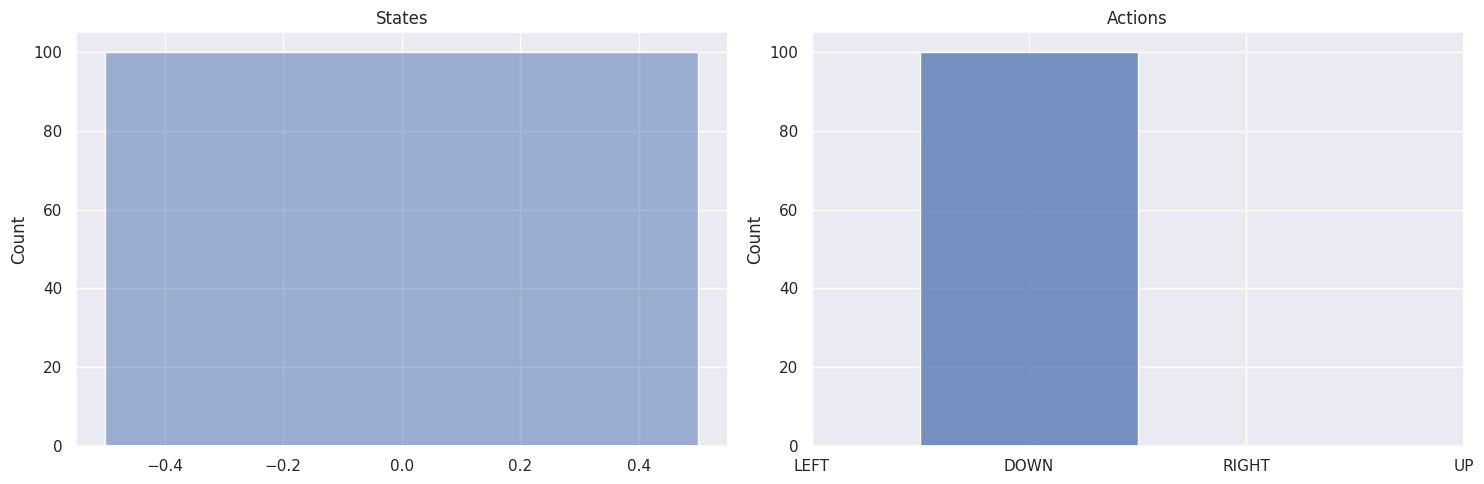

In [16]:
r, st = postprocess(episodes, ht_params1, rewards, steps, map_size)
res_all = pd.concat([res_all, res])
st_all = pd.concat([st_all, st])
plot_states_actions_distribution(states=all_states, actions=all_actions, map_size=map_size)

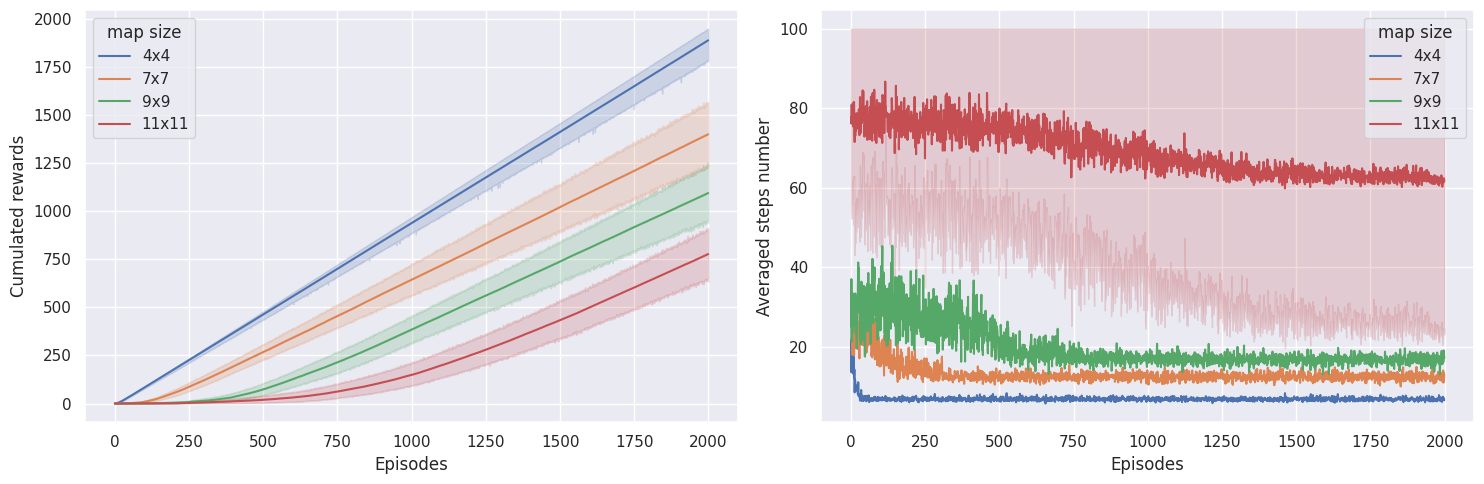

In [17]:
plot_steps_and_rewards(res_all, st_all)

Based on the graphs, THe policy iteration seems to be more efficient in terms of stability and convergence speed. Although both methods are effective, policy iteration algo might provide few advantages over q learning in certain environments. Therefore we can say that policy iteration is prefered for small and predictable environments where as q learning is prefered for large environments where evaluations are performed frequently.

In [18]:
ht_params2 = params._replace(
                    learning_rate=0.8,
                    gamma=0.9,
                    epsilon= 0.5
                )


Map size: 4x4


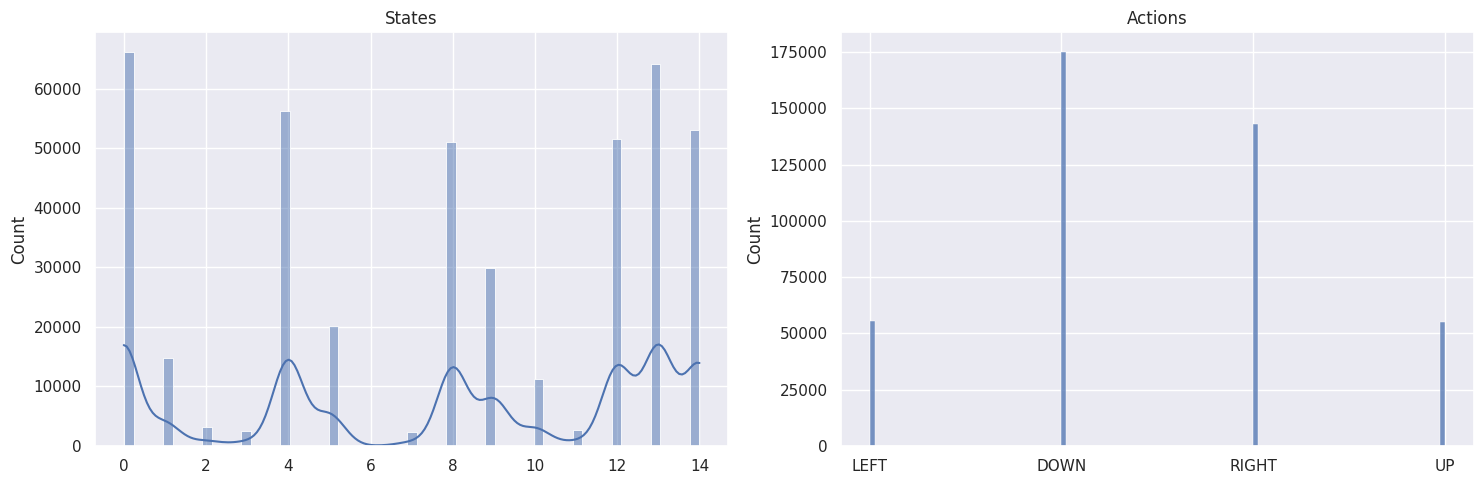

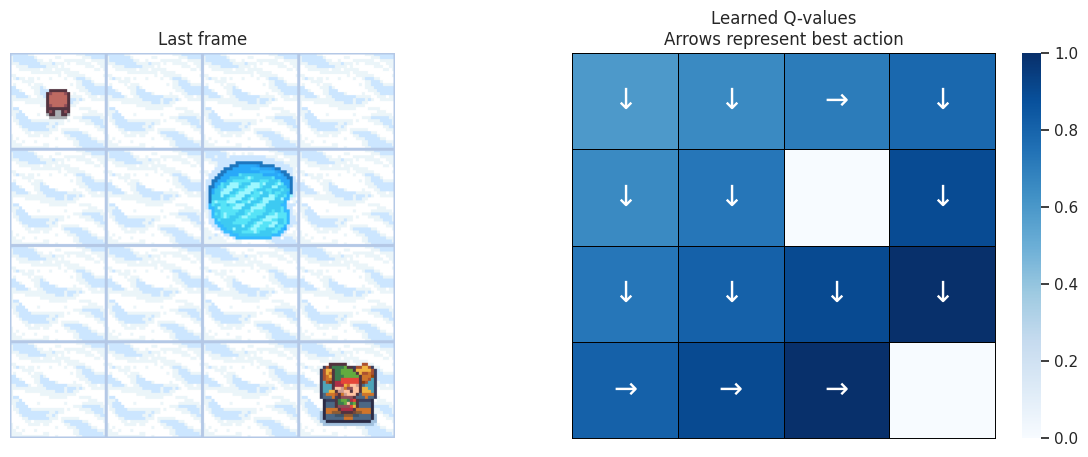

Map size: 7x7


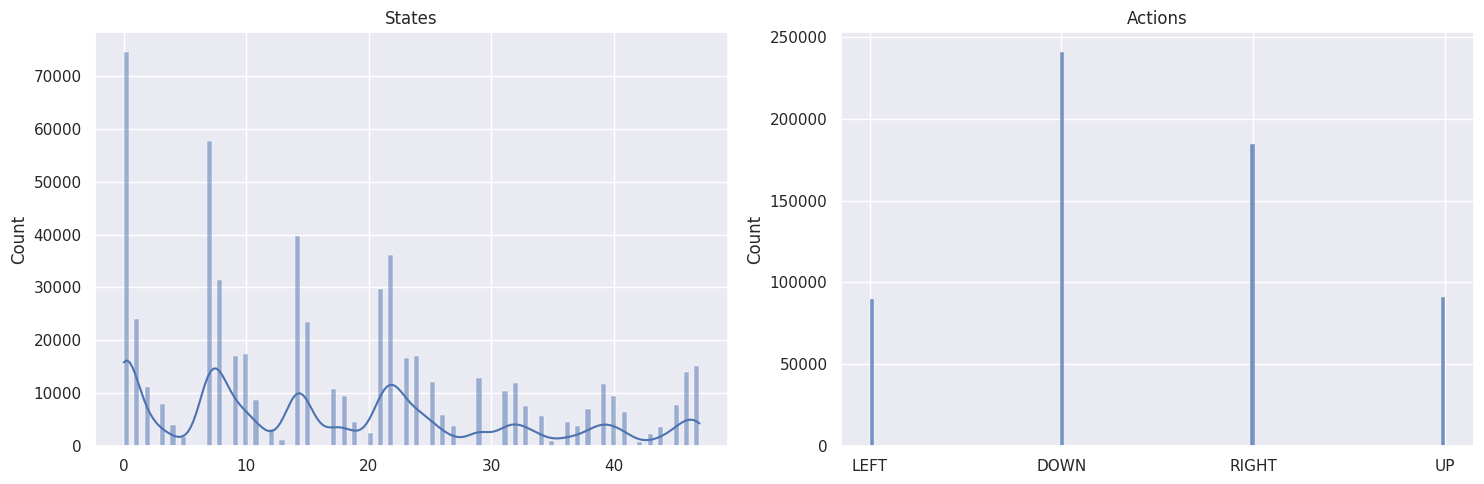

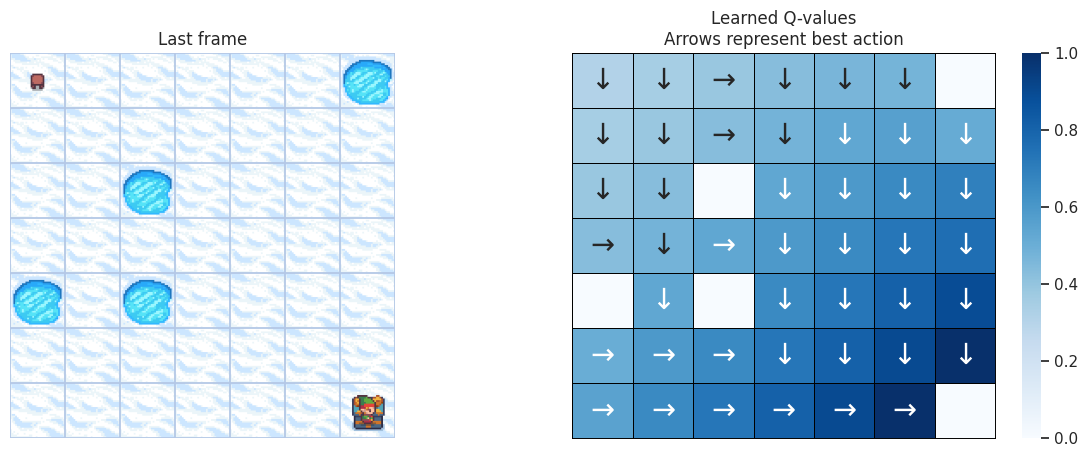

Map size: 9x9


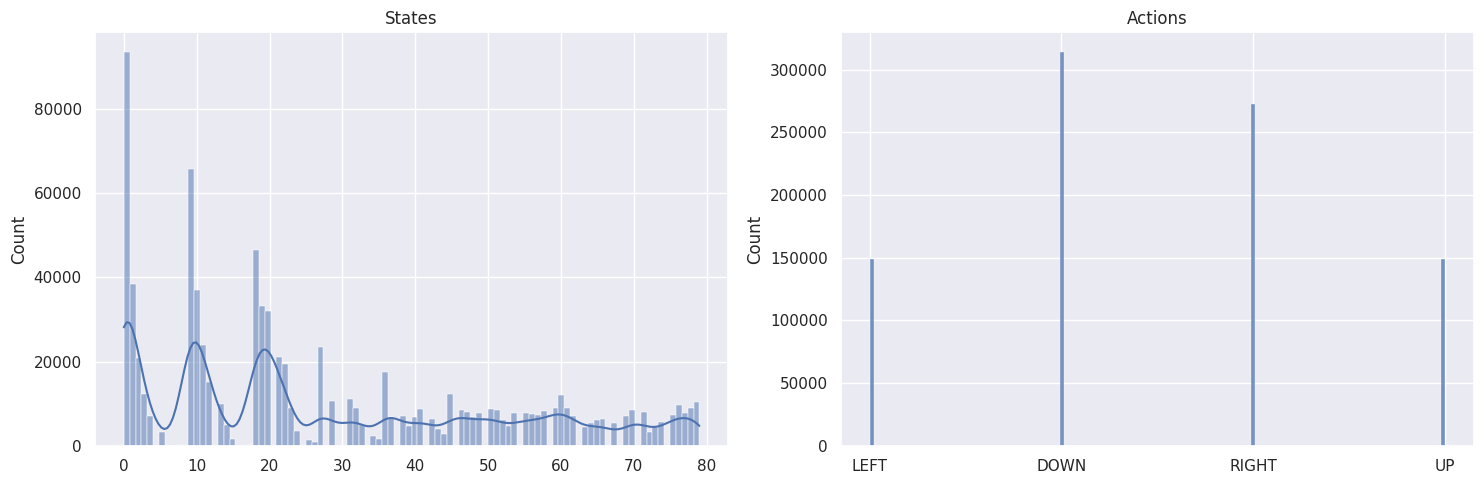

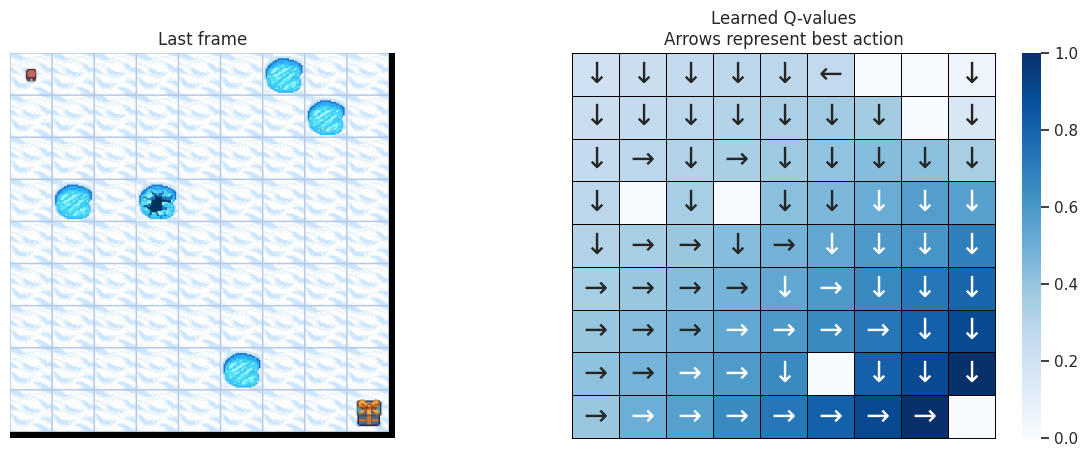

Map size: 11x11


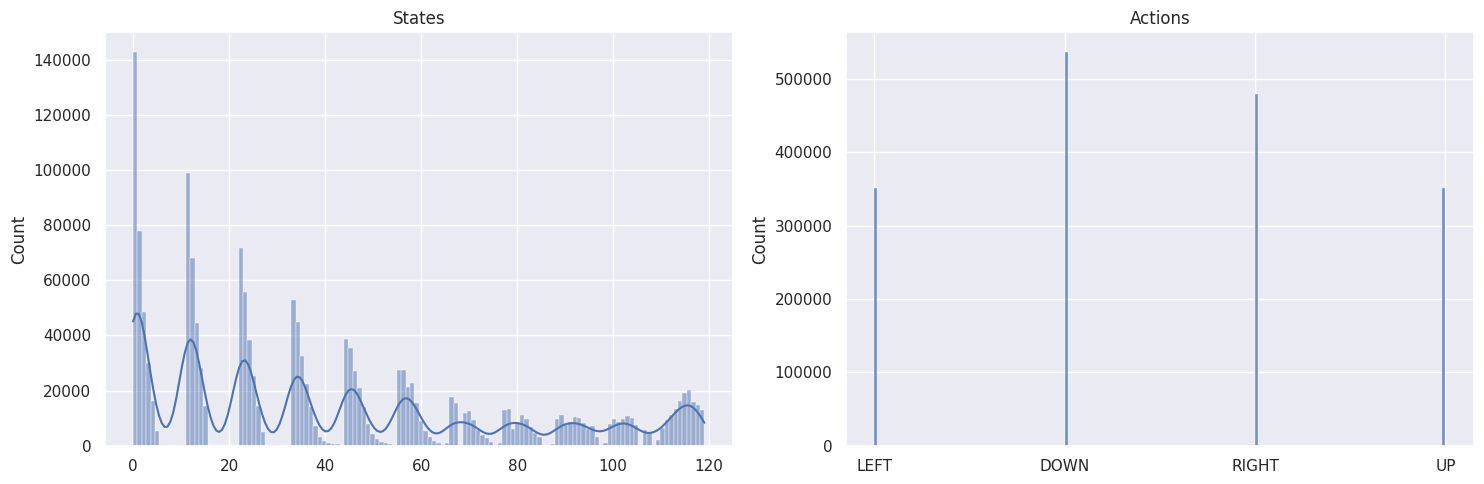

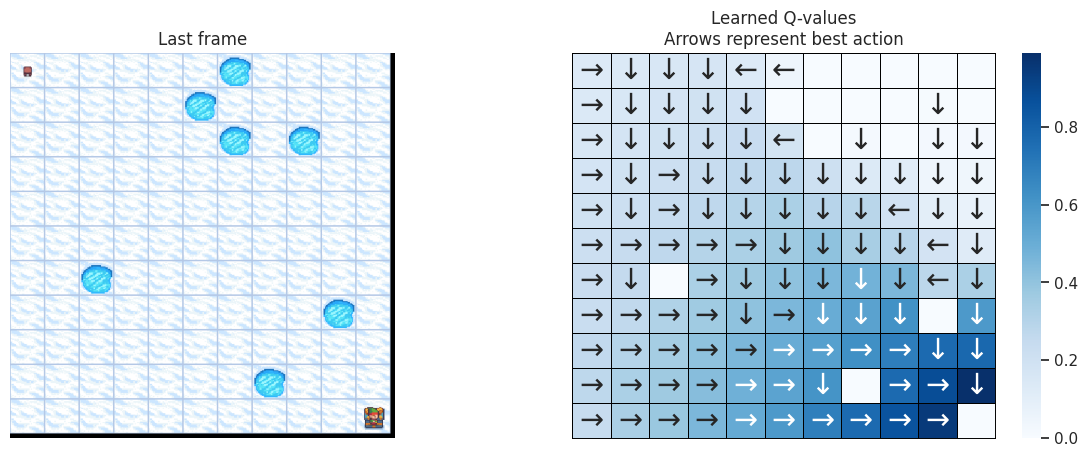

In [19]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=ht_params2.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=ht_params2.proba_frozen, seed=ht_params2.seed
        ),
    )

    ht_params2 = ht_params2._replace(action_size=env.action_space.n)
    ht_params2 = ht_params2._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        ht_params2.seed
    )
    learner = Qlearning(
        learning_rate=ht_params2.learning_rate,
        gamma=ht_params2.gamma,
        state_size=ht_params2.state_size,
        action_size=ht_params2.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=ht_params2.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env(ht_params2)


    res, st = postprocess(episodes, ht_params2, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )
    plot_q_values_map(qtable, env, map_size)

    env.close()

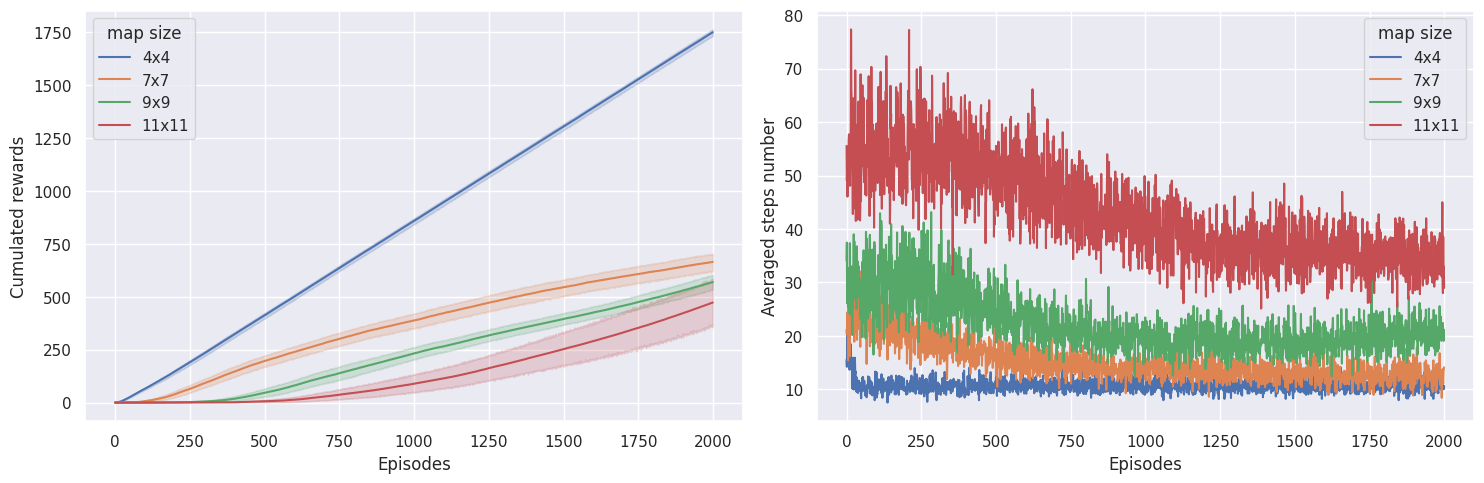

In [20]:
plot_steps_and_rewards(res_all, st_all)

This configuration is effective in faster learning through both aggressive info update and substantial exploration. The agent is able to learn more quickly. Both graphs indicate good performance.  
The decrease in epsilon helped to stabilize the learning. Higher gamma value has improved the performance.

In [21]:
ht_params3 = params._replace(
                    learning_rate=0.1,
                    gamma=0.8,
                    epsilon= 0.9
                )


Map size: 4x4


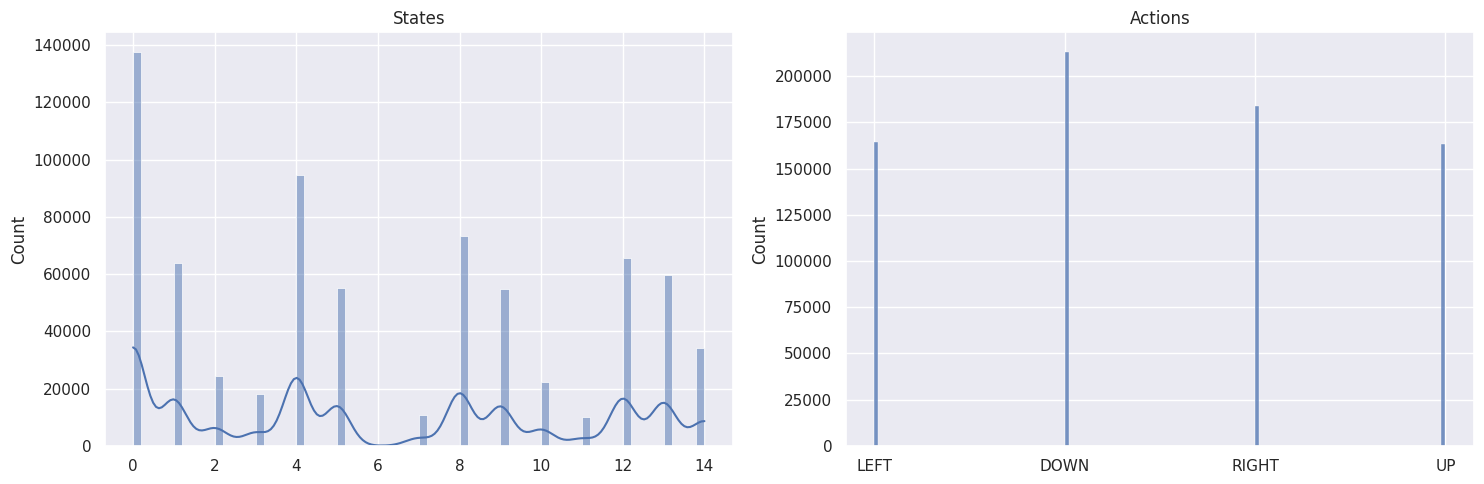

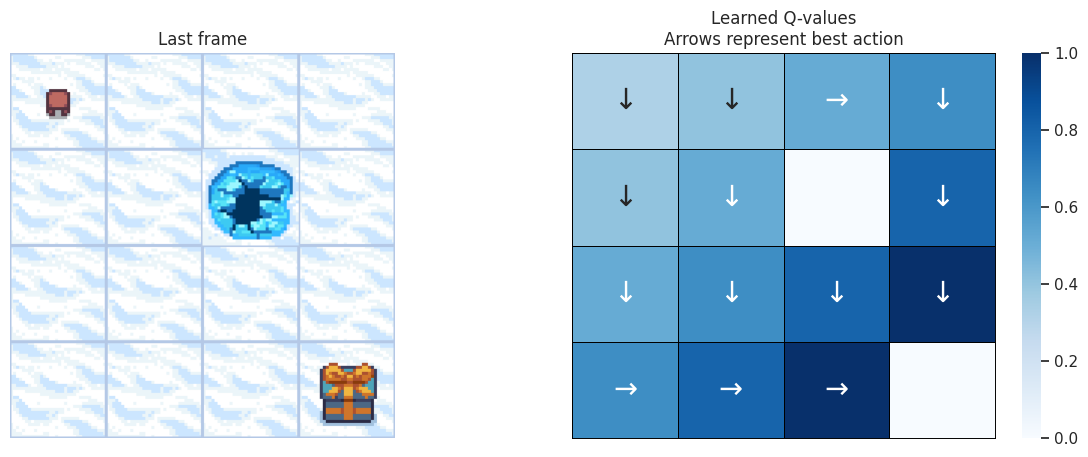

Map size: 7x7


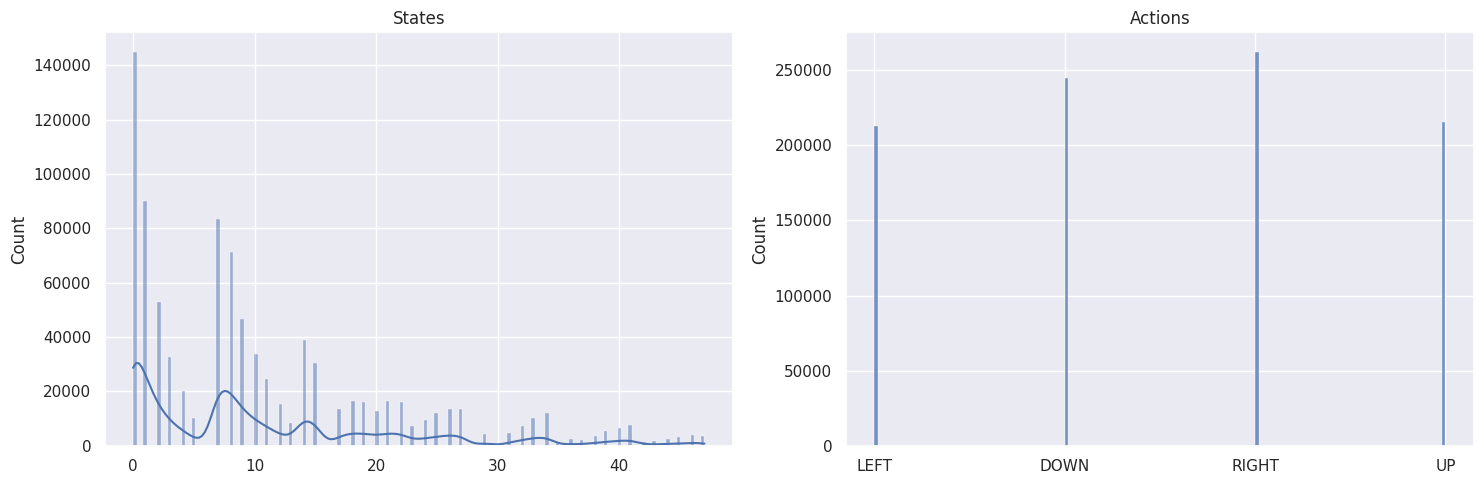

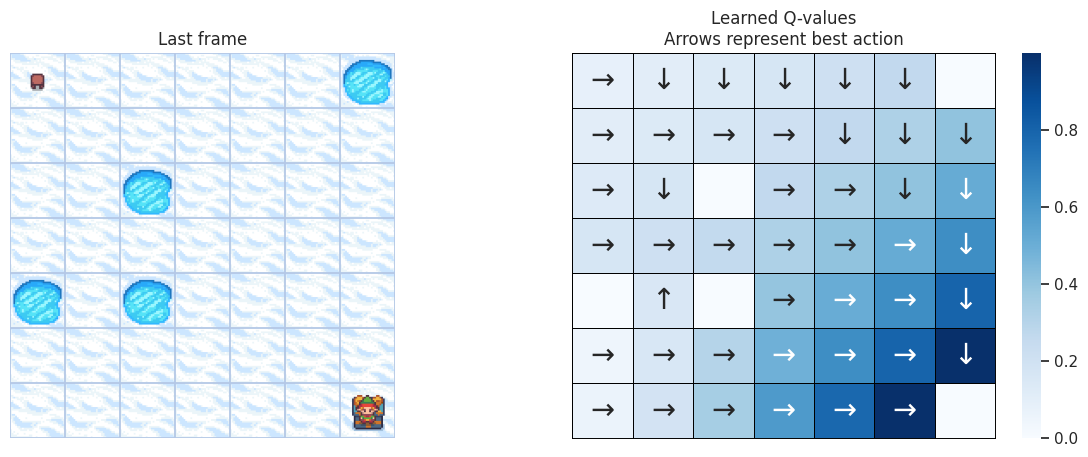

Map size: 9x9


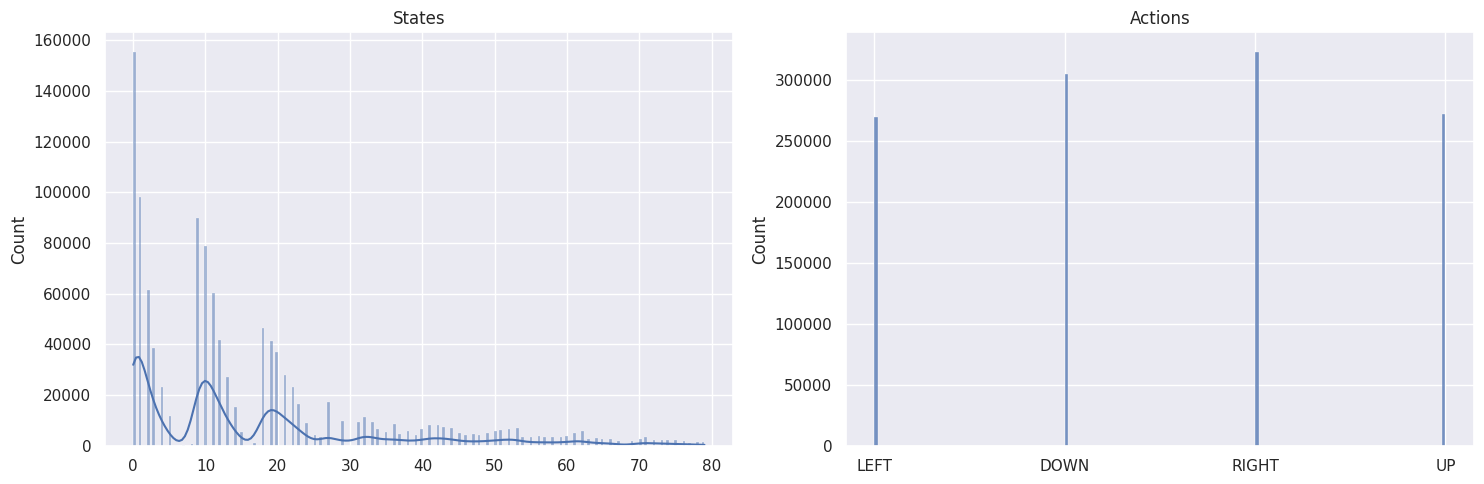

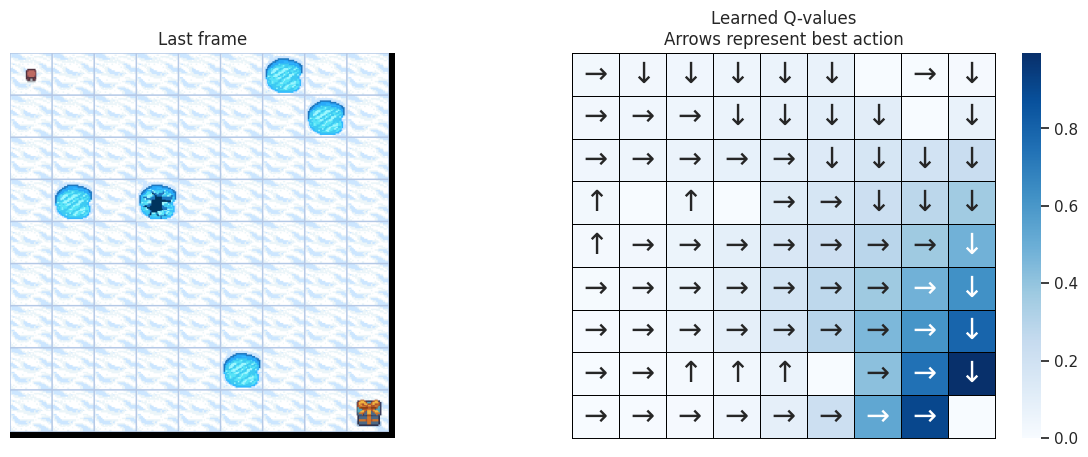

Map size: 11x11


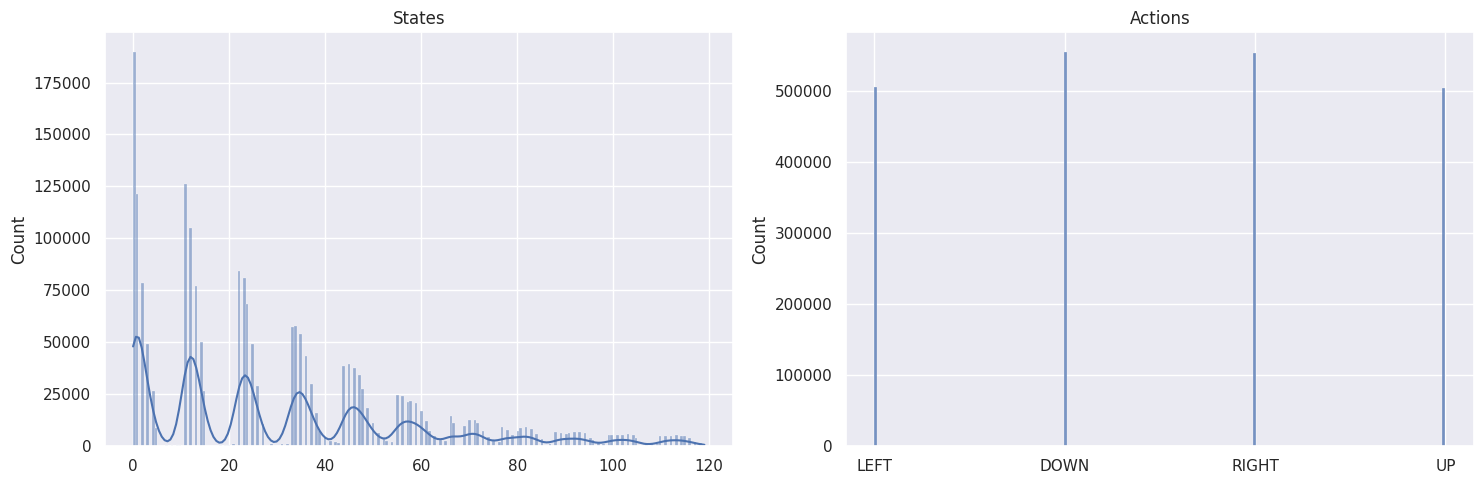

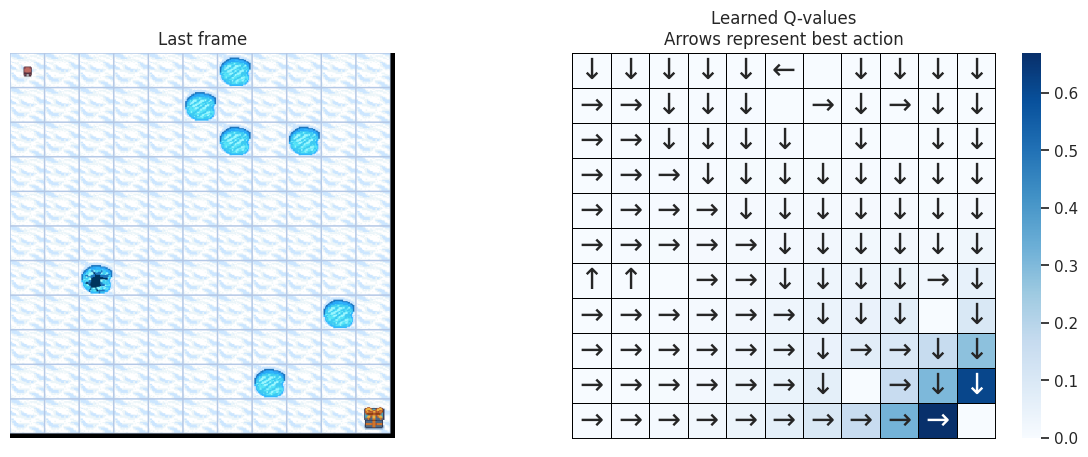

In [22]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=ht_params3.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=ht_params3.proba_frozen, seed=ht_params3.seed
        ),
    )

    ht_params3 = ht_params3._replace(action_size=env.action_space.n)
    ht_params3 = ht_params3._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        ht_params3.seed
    )
    learner = Qlearning(
        learning_rate=ht_params3.learning_rate,
        gamma=ht_params3.gamma,
        state_size=ht_params3.state_size,
        action_size=ht_params3.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=ht_params3.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env(ht_params3)


    res, st = postprocess(episodes, ht_params3, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )
    plot_q_values_map(qtable, env, map_size)

    env.close()

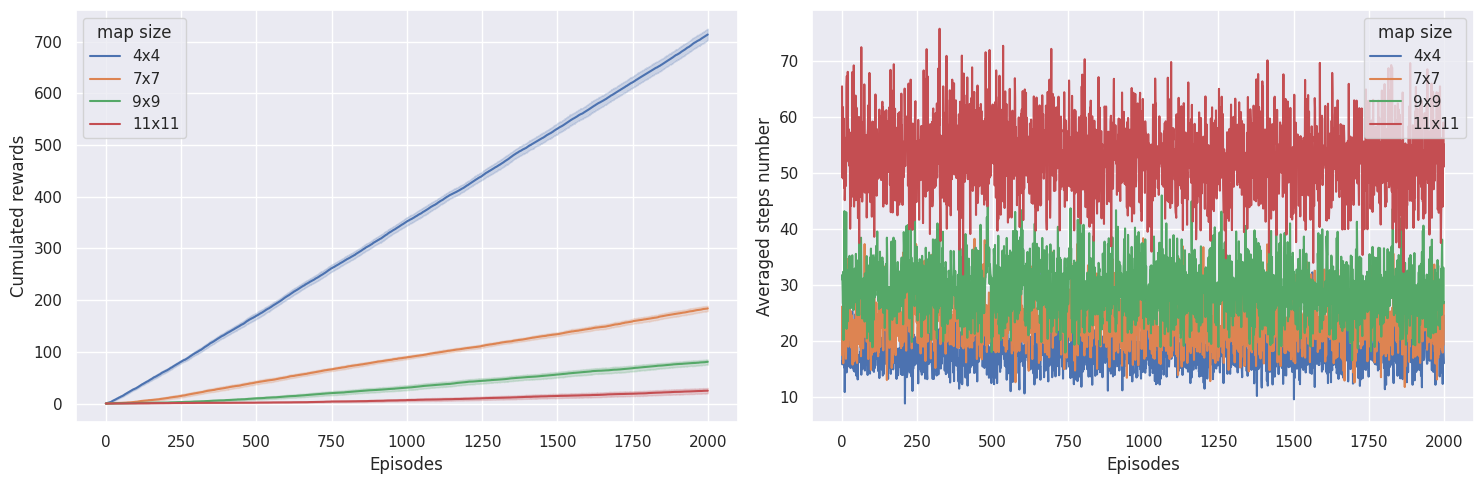

In [23]:
plot_steps_and_rewards(res_all, st_all)

This configuration gave a poor performance compared to other configurations. The alpha needs to increased and Epsilon needs to decreased for better performance.

Conclusion: We have successfully implemented the frozen lake environment, we have taken 3 configurations for hyperparameter tuning. Out of these, 1 and 2 gave good performance and 3 gave a bad performance. Configuratin 1 seems to be the most efficient, so policy iteration algorithm is applied to this set of parameters.

#Part 2

In [1]:
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=f6dd0f62ae6edebea62ca4d5a587166c4543a6ef4265ab00671d16de08a1a43c
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Succ

In [2]:
import numpy as np
import tensorflow as tf
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStack
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers


gamma = 0.99
epsilon = 1.0
epmin = 0.1
epmax = 1.0
epsi = (epmax - epmin)
btch = 32
steps_max = 10000
eps_max = 10
env = gym.make("BreakoutNoFrameskip-v4", mode=4)
env = AtariPreprocessing(env)
env = FrameStack(env, 4)
env.seed(42)
na = 4

def q_modelc():
    return keras.Sequential(
        [
            layers.Lambda(
                lambda tensor: keras.ops.transpose(tensor, [0, 2, 3, 1]),
                output_shape=(84, 84, 4),
                input_shape=(4, 84, 84),
            ),
            layers.Conv2D(32, 8, strides=4, activation="relu", input_shape=(4, 84, 84)),
            layers.Conv2D(64, 4, strides=2, activation="relu"),
            layers.Conv2D(64, 3, strides=1, activation="relu"),
            layers.Flatten(),
            layers.Dense(512, activation="relu"),
            layers.Dense(na, activation="linear"),
        ]
    )


m = q_modelc()
mt = q_modelc()

opt = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

act_hist = []
st_hist = []
stnxt_hist = []
rw_hist = []
dhist = []
epw_hist = []
runrew = 0
epct = 0
frct = 0

erf = 50000
egf = 1000000.0
mmf = 100000
updact = 4
updtn = 10000
lf = keras.losses.Huber()

while True:
    obs, _ = env.reset()
    st = np.array(obs)
    eprw = 0

    for i in range(1, steps_max):
        frct += 1

        if frct < erf or epsilon > np.random.rand(1)[0]:
            act = np.random.choice(na)
        else:
            st_tensor = keras.ops.convert_to_tensor(st)
            st_tensor = keras.ops.expand_dims(st_tensor, 0)
            ap = m(st_tensor, training=False)
            act = keras.ops.argmax(ap[0]).numpy()

        epsilon -= epsi / egf
        epsilon = max(epsilon, epmin)

        stnxt, reward, done, _, _ = env.step(act)
        stnxt = np.array(stnxt)

        eprw += reward

        act_hist.append(act)
        st_hist.append(st)
        stnxt_hist.append(stnxt)
        dhist.append(done)
        rw_hist.append(reward)
        st = stnxt

        if frct % updact == 0 and len(dhist) > btch:
            inds = np.random.choice(range(len(dhist)), size=btch)

            st_sample = np.array([st_hist[i] for i in inds])
            stnxt_sample = np.array([stnxt_hist[i] for i in inds])
            rw_sample = [rw_hist[i] for i in inds]
            act_sample = [act_hist[i] for i in inds]
            done_sample = keras.ops.convert_to_tensor(
                [float(dhist[i]) for i in inds]
            )

            future_rewards = mt.predict(stnxt_sample)
            uqv = rw_sample + gamma * keras.ops.amax(
                future_rewards, axis=1
            )

            uqv = uqv * (1 - done_sample) - done_sample

            masks = keras.ops.one_hot(act_sample, na)

            with tf.GradientTape() as tape:
                q_values = m(st_sample)

                q_action = keras.ops.sum(keras.ops.multiply(q_values, masks), axis=1)
                loss = lf(uqv, q_action)

            grads = tape.gradient(loss, m.trainable_variables)
            opt.apply_gradients(zip(grads, m.trainable_variables))

        if frct % updtn == 0:
            mt.set_weights(m.get_weights())
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(runrew, epct, frct))

        if len(rw_hist) > mmf:
            del rw_hist[:1]
            del st_hist[:1]
            del stnxt_hist[:1]
            del act_hist[:1]
            del dhist[:1]

        if done:
            break

    epw_hist.append(eprw)
    if len(epw_hist) > 100:
        del epw_hist[:1]
    runrew = np.mean(epw_hist)

    epct += 1

    if runrew > 40:
        print("Solved at episode {}!".format(epct))
        break


    if (eps_max > 0 and epct >= eps_max):
        print("Stopped at episode {}!".format(epct))
        break

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
def display_episode_rewards(rewards_each_episode):
    plt.figure(figsize=(10,5))
    plt.plot(rewards_each_episode, label='Episode Rewards')
    plt.xlabel('Episode Count')
    plt.ylabel('Rewards Accumulated')
    plt.title('Episode-wise Reward Tracking')
    plt.legend()
    plt.grid(True)
    plt.show()

def show_action_frequency(actions_recorded, total_actions):
    plt.figure(figsize=(10, 5))
    sns.histplot(actions_recorded, bins=total_actions, kde=False, color='blue')
    plt.title('Frequency of Actions Over Episodes')
    plt.xlabel('Type of Action')
    plt.ylabel('Occurrence Count')
    plt.xticks(ticks=range(total_actions), labels=[f'Action {i}' for i in range(total_actions)])
    plt.show()





/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


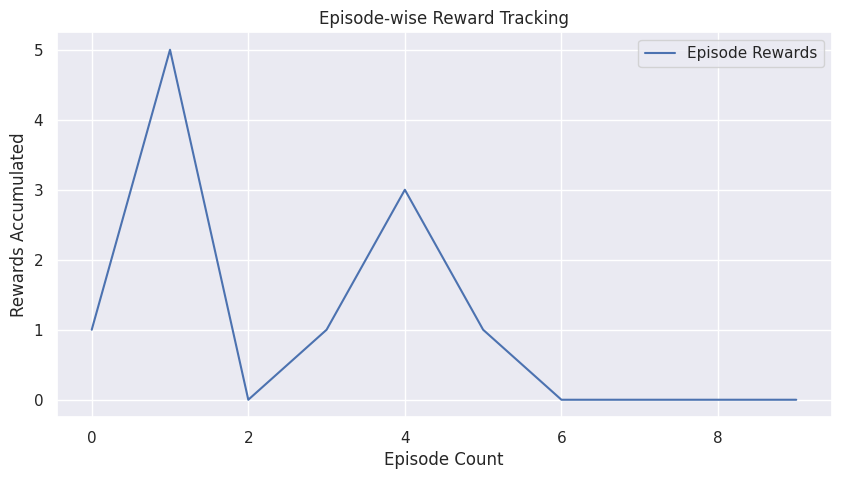

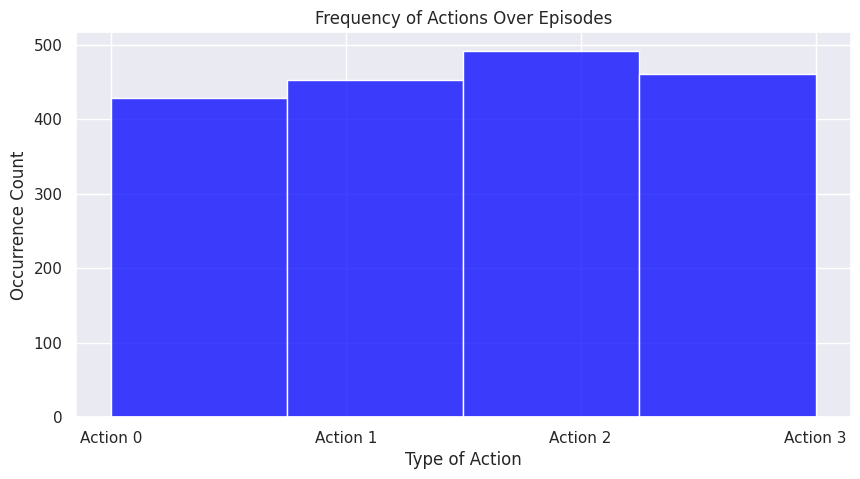

In [4]:
display_episode_rewards(epw_hist)
show_action_frequency(act_hist, env.action_space.n)